In [1]:
%cd ~/Desktop/Paris_Cite/Year2/Projet_Long/PoincareMSA

#Load outside module dependencies
import os
import numpy as np
import pandas as pd
import subprocess
import json
import warnings
warnings.filterwarnings('ignore')
import scipy

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import plotly.express as px
import umap

#Import local functions
from scripts.visualize_projection.pplots_new import read_embeddings, plot_embedding, plot_embedding_interactive, rotate, get_colors
from scripts.build_poincare_map.data import construct_tensor_from_embedding, prepare_embedding_data, prepare_data
%matplotlib inline

from scripts.build_poincare_map.poincare_maps import *
from scripts.build_poincare_map.embedding_quality_score import *

/Users/gabrielduval/Desktop/Paris_Cite/Year2/Projet_Long/PoincareMSA


In [2]:
#from scripts.build_poincare_map.kmedoids import *
from sklearn import metrics
from sklearn.cluster import *

def get_scores(t_labels, labels):
    ARS = metrics.adjusted_rand_score(t_labels, labels)
    FMS = metrics.fowlkes_mallows_score(t_labels, labels)
    
    return ARS, FMS

def detect_cluster(D, n_clusters=2, clustering_name='spectral', k=5, class_exclude = "OTHER"): #distances='Poincaré',
    if clustering_name == 'spectral':
        similarity = np.exp(-D**2)
        clustering = SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack', 
                                        affinity='precomputed', n_neighbors=k).fit(similarity)
        labels = clustering.labels_
    elif clustering_name == 'kmedoids':
        clustering = kMedoids(D, n_clusters, tmax=10000)
        labels = clustering
    else:
        #clustering = AgglomerativeClustering(linkage='average', n_clusters=n_clusters, 
        #                                     affinity='precomputed').fit(D)
        clustering = AgglomerativeClustering(linkage='average', n_clusters=n_clusters).fit(D)
        labels = clustering.labels_
            
    return labels

Labels and number of clusters:

In [12]:
knn = 5
gamma = 2
sigma = 1
cospca = 0
batchs = 4
epochs = 1000
seed = 0

out_name = "results/globins/with_mfasta"
path_annotation = "examples/globins/globin_colors_new.csv"
path_embedding = f"{out_name}/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
print(df_embedding)
df_embedding.replace("Other", "OTHER")

          pm1       pm2  proteins_id
0    0.165887  0.005420            1
1   -0.020971 -0.228163            2
2    0.134721 -0.211576            3
3    0.308206 -0.367629            4
4    0.233765 -0.321833            5
..        ...       ...          ...
247  0.189355  0.761364          248
248  0.229197  0.729397          249
249  0.186366  0.717289          250
250  0.175210  0.725011          251
251  0.798315  0.290697          252

[252 rows x 3 columns]
                  pm1       pm2 proteins_id tree1 tree2 tree3 tree4  \
proteins_id                                                           
1            0.165887  0.005420           1     5     3     3     2   
2           -0.020971 -0.228163           2    -1    28    18    10   
3            0.134721 -0.211576           3    -1    27    18    10   
4            0.308206 -0.367629           4    37    27    18    10   
5            0.233765 -0.321833           5    37    27    18    10   
...               ...       ...    

,pm1,pm2,proteins_id,tree1,tree2,tree3,tree4,full_name,short_name,full_species,short_species,evo_distance,Color_species,Domain,Kingdom,Phylum,Subphylum,Class,Genus
proteins_id,,,,,,,,,,,,,,,,,,,
1,0.165887,0.005420,1,5,3,3,2,"Globin C, coelomic",Globin,Caudina arenicola,Caudina,2.101128,Echinodermata,Eukaryota,Metazoa,Echinodermata,OTHER,OTHER,OTHER
2,-0.020971,-0.228163,2,-1,28,18,10,Globin (Fragment),Globin,Stegodyphus mimosarum,Stegodyphus,1.757280,Arthropoda,Eukaryota,Metazoa,Arthropoda,Chelicerata,Arachnida,OTHER
3,0.134721,-0.211576,3,-1,27,18,10,Uncharacterized protein,Uncharacterized,Strigamia maritima,Strigamia,2.041487,Arthropoda,Eukaryota,Metazoa,Arthropoda,OTHER,OTHER,OTHER
4,0.308206,-0.367629,4,37,27,18,10,Uncharacterized protein,Uncharacterized,Scylla olivacea,Scylla,2.318169,Arthropoda,Eukaryota,Metazoa,Arthropoda,Crustacea,Malacostraca,OTHER
5,0.233765,-0.321833,5,37,27,18,10,Uncharacterized protein,Uncharacterized,Scylla olivacea,Scylla,2.170775,Arthropoda,Eukaryota,Metazoa,Arthropoda,Crustacea,Malacostraca,OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.189355,0.761364,248,14,10,9,3,Uncharacterized protein,Uncharacterized,Strongylocentrotus purpuratus,Strongylocentrotus,2.586926,Echinodermata,Eukaryota,Metazoa,Echinodermata,OTHER,Echinoidea,Strongylocentrotus
249,0.229197,0.729397,249,-1,10,9,3,Uncharacterized protein,Uncharacterized,Strongylocentrotus purpuratus,Strongylocentrotus,2.519191,Echinodermata,Eukaryota,Metazoa,Echinodermata,OTHER,Echinoidea,Strongylocentrotus
250,0.186366,0.717289,250,14,10,9,3,Uncharacterized protein,Uncharacterized,Strongylocentrotus purpuratus,Strongylocentrotus,2.276065,Echinodermata,Eukaryota,Metazoa,Echinodermata,OTHER,Echinoidea,Strongylocentrotus


In [4]:
poincare_coord = pd.read_csv(path_embedding, sep=',').sort_values(by=["proteins_id"])
poincare_coord = poincare_coord.values[:,:2]
print(poincare_coord[0, 0])
model = PoincareMaps(poincare_coord)
model.get_distances()

0.16588654


# Comparison of different scores for Poincaré vs other methods

Prepare feature file for other methods.

In [13]:
# VERY IMPORTANT - Features must be loaded in sorted python order, because the read_embedding
# function sorts the results csv based on protein id. 

# For mfasta poincare
fasta_files = 'examples/globins/globins_data'

n_proteins = df_embedding.shape[0]
x = np.array(np.loadtxt(fasta_files + "/fasta0.9/1.aamtx").reshape(-1))
len_prot = len(x)

features = np.zeros([n_proteins, len_prot])

for i in range(n_proteins):
    #print(out_name + "/fasta0.9/" + str(i) + ".aamtx")
    x = np.array(np.loadtxt(fasta_files + "/fasta0.9/" + str(i+1) + ".aamtx").reshape(-1))
    features[i,:] = x

# For embedding poincare
# out_name = 'examples/globins/globins_data'

# n_proteins = df_embedding.shape[0]
# x = np.array(np.loadtxt(out_name + "/fasta0.9/1.aamtx").reshape(-1))
# len_prot = len(x)

# features = np.zeros([n_proteins, len_prot])

# for i in range(n_proteins):
#     #print(out_name + "/fasta0.9/" + str(i) + ".aamtx")
#     x = np.array(np.loadtxt(out_name + "/fasta0.9/" + str(i+1) + ".aamtx").reshape(-1))
#     features[i,:] = x

Calculate original distances:

In [14]:
D_raw = pairwise_distances(features, metric="cosine")
print(df_embedding['pm1'])

proteins_id
1      0.165887
2     -0.020971
3      0.134721
4      0.308206
5      0.233765
         ...   
248    0.189355
249    0.229197
250    0.186366
251    0.175210
252    0.798315
Name: pm1, Length: 252, dtype: float64


# SET PARAMETERS

In [15]:
df_results_clust = pd.DataFrame()
df_results_proj = pd.DataFrame()

In [16]:
k_neigh = knn

# by names/family
true_col = "short_name"# "short_species"# 
other = "Uncharacterized" 

# by phylogenetic cluster
#true_col = "tree4"
#other = -1 

# by new annotation
#true_col = "Phylum"
#other = "OTHER" 


remove_others = True
remove_outliers = True

#print(df_embedding[df_embedding[true_col]!=other].shape)

expected_nc = df_embedding[true_col].unique().size

#print(df_embedding[true_col].value_counts())
#print(df_embedding[df_embedding[true_col].duplicated(keep=False)])

# Remove classes of size 1
no_outliers = df_embedding[true_col].duplicated(keep=False)
#print(df_embedding[no_outliers].shape)
nc =  expected_nc

print("Number of expected classes: ", expected_nc)

Number of expected classes:  26


In [17]:
# Construction of custom color palette 
globin_palette = {'Echinodermata': '#086b75', 'Arthropoda': '#0b237c', 'Mollusca': '#512ff8', 'Annelida': '#a191f3', 'Chordata': '#26c9d9', 'Cnidaria': '#ad288b', 'Porifera': '#fdb7fd', 'Placozoa': '#e9bd6b', 'Bacteria': '#f10000', 'Nematoda': '#5d78e3', 'Hemichordata': '#b0ffe8', 'Fungi': '#a0e361', 'Viridiplantae': '#4d9b03'}

# ALL TOGETHER

## Evaluate clustering

In [18]:
cname = 'agglomerative'
setting = "manifold" # "global" # 

for seed in range(5):
    # read poincare and annotations
    path_embedding = f"{out_name}/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
    df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
    df_embedding.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = df_embedding[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model = PoincareMaps(poincare_coord)
    model.get_distances()
    # poincare scores
    clusters = detect_cluster(model.distances, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_poincare"] = clusters
    df_embedding["clust_poincare"] = df_embedding["clust_poincare"].astype("string")
    # MDS scores
    X_cosine = pairwise_distances(features,metric='cosine')
    X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
    df_embedding["x1_mds"] = X_mds[:,0]
    df_embedding["x2_mds"] = X_mds[:,1]
    D = pairwise_distances(X_mds)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_mds"] = clusters
    df_embedding["clust_mds"] = df_embedding["clust_mds"].astype("string")
    # tSNE scores
    X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
    df_embedding["x1_tsne"] = X_tsne[:,0]
    df_embedding["x2_tsne"] = X_tsne[:,1]
    D = pairwise_distances(X_tsne)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_tsne"] = clusters
    df_embedding["clust_tsne"] = df_embedding["clust_tsne"].astype("string")
    # UMAP scores
    X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
    df_embedding["x1_umap"] = X_umap[:,0]
    df_embedding["x2_umap"] = X_umap[:,1]
    D = pairwise_distances(X_umap)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)
    df_embedding["clust_umap"] = clusters
    df_embedding["clust_umap"] = df_embedding["clust_umap"].astype("string")
    # PCA scores
    X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features)
    df_embedding["x1_pca"] = X_pca[:,0]
    df_embedding["x2_pca"] = X_pca[:,1]
    D = pairwise_distances(X_pca)
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_pca"] = clusters
    df_embedding["clust_pca"] = df_embedding["clust_pca"].astype("string")
    
    # clustering
    if remove_outliers:
        df_noothers = df_embedding[no_outliers]
    if remove_others:
        df_noothers = df_noothers[df_embedding[true_col]!=other]
    
    for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:

        ARI, FMS = get_scores(df_noothers[true_col], df_noothers["clust_" + clust_meth])

        if clust_meth == "poincare":
            D = model.distances
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting=setting, k_neighbours=5)
        else:
            D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting=setting, k_neighbours=5)

        corr = scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0)
    
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "nc": [nc], "true_col": [true_col], "ARI": [ARI], "FMS": [FMS]})
        df_results_clust = pd.concat([df_results_clust, df])
        
        # print(df_Q.Qnx.to_numpy())
        
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "Kmax": [Kmax], "Qnx": [df_Q.Qnx.to_numpy()]})
        df_results_proj = pd.concat([df_results_proj, df])


#print(df_results)

          pm1       pm2  proteins_id
0    0.165887  0.005420            1
1   -0.020971 -0.228163            2
2    0.134721 -0.211576            3
3    0.308206 -0.367629            4
4    0.233765 -0.321833            5
..        ...       ...          ...
247  0.189355  0.761364          248
248  0.229197  0.729397          249
249  0.186366  0.717289          250
250  0.175210  0.725011          251
251  0.798315  0.290697          252

[252 rows x 3 columns]
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
          pm1       pm2  proteins_id
0   -0.198498 -0.202702            1
1   -0.303557 -0.007796            2
2   -0.421813 -0.107958            3
3   -0.637956 -0.090386            4
4   -0.558838 -0.123564            5
..        ...       ...          ...
247  0.816202 -0.016961          248
248  0.853925 -0.047275          249
249  0.810471 -0.053826          250
250  0.838430 -0.101526          251
251  0.407965  0.727344          252

[252 rows x 3 columns]

In [19]:
print(df_results_proj.head(10))

     method  seed    Qlocal   Qglobal  Kmax  \
0  poincare     0  0.580677  0.837846     5   
0       mds     0  0.348434  0.659643     6   
0      tsne     0  0.809524  0.747712     0   
0      umap     0  0.583675  0.755817     5   
0       pca     0  0.322498  0.688014    13   
0  poincare     1  0.610527  0.840275     6   
0       mds     1  0.378293  0.682376     9   
0      tsne     1  0.809524  0.747184     0   
0      umap     1  0.600997  0.748568     6   
0       pca     1  0.322498  0.688014    13   

                                                 Qnx  
0  [0.3611111111111111, 0.4642857142857143, 0.579...  
0  [0.21031746031746032, 0.30753968253968256, 0.3...  
0  [0.8095238095238095, 0.7698412698412699, 0.743...  
0  [0.3253968253968254, 0.5099206349206349, 0.621...  
0  [0.09523809523809523, 0.2003968253968254, 0.24...  
0  [0.36904761904761907, 0.49603174603174605, 0.5...  
0  [0.2857142857142857, 0.32936507936507936, 0.35...  
0  [0.8095238095238095, 0.7757936507936508

In [18]:
fig = px.strip(df_results_clust, x='method', y='FMS', color = "true_col")
fig.update_yaxes(range = [0,1])
fig.show()

In [237]:
fig.write_image("FMS_globins.pdf")

## Evaluate projection

In [26]:
df_results_proj = pd.DataFrame()

In [27]:
cname = 'agglomerative'
setting = "manifold" # "global" # 

for seed in range(5):
    # read poincare and annotations
    path_embedding = f"{out_name}/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
    df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)
    df_embedding.replace("Other", "OTHER")
    # calculate poincare distances
    poincare_coord = df_embedding[["pm1","pm2"]]
    poincare_coord = poincare_coord.values
    #print(poincare_coord)
    model = PoincareMaps(poincare_coord)
    model.get_distances()
    # MDS scores
    X_cosine = pairwise_distances(features,metric='cosine')
    X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
    df_embedding["x1_mds"] = X_mds[:,0]
    df_embedding["x2_mds"] = X_mds[:,1]
    # tSNE scores
    X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
    df_embedding["x1_tsne"] = X_tsne[:,0]
    df_embedding["x2_tsne"] = X_tsne[:,1]
    # UMAP scores
    X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
    df_embedding["x1_umap"] = X_umap[:,0]
    df_embedding["x2_umap"] = X_umap[:,1]
    # PCA scores
    X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features)
    df_embedding["x1_pca"] = X_pca[:,0]
    df_embedding["x2_pca"] = X_pca[:,1]
    
    
    for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:

        if clust_meth == "poincare":
            D = model.distances
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting=setting, k_neighbours=5)
        else:
            D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
            Qlocal, Qglobal, Kmax, df_Q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting=setting, k_neighbours=5)

        corr = scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0)
    
        
        df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "Kmax": [Kmax], "Qnx": [df_Q.Qnx.to_numpy()]})
        df_results_proj = pd.concat([df_results_clust, df])

#print(df_results)

          pm1       pm2  proteins_id
0    0.165887  0.005420            1
1   -0.020971 -0.228163            2
2    0.134721 -0.211576            3
3    0.308206 -0.367629            4
4    0.233765 -0.321833            5
..        ...       ...          ...
247  0.189355  0.761364          248
248  0.229197  0.729397          249
249  0.186366  0.717289          250
250  0.175210  0.725011          251
251  0.798315  0.290697          252

[252 rows x 3 columns]
Connecting 2
Connecting 2
Connecting 2
Connecting 2
Connecting 2
          pm1       pm2  proteins_id
0   -0.198498 -0.202702            1
1   -0.303557 -0.007796            2
2   -0.421813 -0.107958            3
3   -0.637956 -0.090386            4
4   -0.558838 -0.123564            5
..        ...       ...          ...
247  0.816202 -0.016961          248
248  0.853925 -0.047275          249
249  0.810471 -0.053826          250
250  0.838430 -0.101526          251
251  0.407965  0.727344          252

[252 rows x 3 columns]

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
print(sns.color_palette(palette=None, n_colors=5).as_hex())
meth_palette = dict(zip(["poincare", "mds", "tsne", "umap", "pca"], sns.color_palette(palette=None, n_colors=5).as_hex()))
print(meth_palette)

['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3']
{'poincare': '#4c72b0', 'mds': '#dd8452', 'tsne': '#55a868', 'umap': '#c44e52', 'pca': '#8172b3'}


poincare 0.83, 0.01
mds 0.66, 0.01
tsne 0.75, 0.00
umap 0.72, 0.02
pca 0.67, 0.00


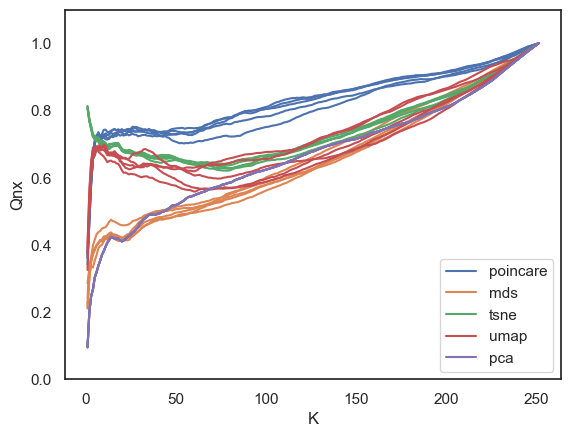

In [25]:
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    Qnx_mean = []

    for seed in range(5):
        xx = df_results_proj[(df_results_proj.method==clust_meth)&(df_results_proj.seed==seed)].Qnx.values
        xx = xx.squeeze()[()]
        Qnx_mean.append(xx.mean())
        #print(len(xx))
        #fig = px.line(x = range(1,len(xx)+1), y= xx)
        if seed == 0:
            sns.lineplot(x = range(1,len(xx)+1), y = xx, color = meth_palette[clust_meth], label = clust_meth)
        else:
            sns.lineplot(x = range(1,len(xx)+1), y = xx, color = meth_palette[clust_meth])#, label = clust_meth)
    print(clust_meth, "%2.2f, %2.2f"%(np.mean(Qnx_mean), np.std(Qnx_mean)))

#plt.legend()
plt.xlabel("K")
plt.ylabel("Qnx")
plt.ylim([0,1.1])
#plt.savefig("Qnx_global_kinases.pdf")
plt.show()

In [262]:
print("Local")
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    print(clust_meth, "%2.2f, %2.2f"%(df_results_proj[(df_results_proj.method==clust_meth)].Qlocal.values.mean(), df_results_proj[(df_results_proj.method==clust_meth)].Qlocal.values.std()))
    
print("Global")   
for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:
    print(clust_meth, "%2.2f, %2.2f"%(df_results_proj[(df_results_proj.method==clust_meth)].Qglobal.values.mean(), df_results_proj[(df_results_proj.method==clust_meth)].Qglobal.values.std()))

Local
poincare 0.60, 0.02
mds 0.37, 0.02
tsne 0.81, 0.01
umap 0.59, 0.02
pca 0.32, 0.00
Global
poincare 0.83, 0.01
mds 0.67, 0.01
tsne 0.75, 0.01
umap 0.72, 0.02
pca 0.69, 0.00


# 
# 
# 

### Poincaré distances hyperboliques 

In [ ]:
for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(model.distances, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_poincare"] = clusters
    df_embedding["clust_poincare"] = df_embedding["clust_poincare"].astype("string")

### MDS

In [ ]:
X_cosine = pairwise_distances(features,metric='cosine')
X_mds = MDS(metric=True,dissimilarity='precomputed', random_state = seed).fit_transform(X_cosine)
df_embedding["x1_mds"] = X_mds[:,0]
df_embedding["x2_mds"] = X_mds[:,1]

In [ ]:
D = pairwise_distances(X_mds)
print(D.shape)

for cname in ['agglomerative']:#,'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_mds"] = clusters
    df_embedding["clust_mds"] = df_embedding["clust_mds"].astype("string")

### t-SNE

In [ ]:
X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
df_embedding["x1_tsne"] = X_tsne[:,0]
df_embedding["x2_tsne"] = X_tsne[:,1]

In [ ]:
D = pairwise_distances(X_tsne)

for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_tsne"] = clusters
    df_embedding["clust_tsne"] = df_embedding["clust_tsne"].astype("string")

### UMAP

In [ ]:
X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
df_embedding["x1_umap"] = X_umap[:,0]
df_embedding["x2_umap"] = X_umap[:,1]

In [ ]:
D = pairwise_distances(X_umap)
print(D.shape)

for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_umap"] = clusters
    df_embedding["clust_umap"] = df_embedding["clust_umap"].astype("string")

### PCA

In [ ]:
X_pca = KernelPCA(kernel='cosine', random_state = seed).fit_transform(features)
df_embedding["x1_pca"] = X_pca[:,0]
df_embedding["x2_pca"] = X_pca[:,1]

In [ ]:
D = pairwise_distances(X_pca)
print(D.shape)


for cname in ['agglomerative']:#, 'spectral']:#, 'agglomerative', 'kmedoids']:
    clusters = detect_cluster(D, n_clusters=nc, clustering_name=cname)#, k=15)
    df_embedding["clust_pca"] = clusters
    df_embedding["clust_pca"] = df_embedding["clust_pca"].astype("string")

## Compare scores for clustering

In [ ]:
if remove_outliers:
    df_noothers = df_embedding[no_outliers]
if remove_others:
    df_noothers = df_noothers[df_embedding[true_col]!=other]
        
print(df_embedding.shape, df_noothers.shape)

for clust_meth in ["poincare", "mds", "tsne", "umap", "pca"]:

    ARI, FMS = get_scores(df_noothers[true_col], df_noothers["clust_" + clust_meth])

    if clust_meth == "poincare":
        D = model.distances
        Qlocal, Qglobal, Kmax = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting="manifold", k_neighbours=5)
    else:
        D = pairwise_distances(df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth])
        Qlocal, Qglobal, Kmax = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting="manifold", k_neighbours=5)

    corr = scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0)
    
    df = pd.DataFrame({"method": [clust_meth], "seed": [seed], "Qlocal": [Qlocal], "Qglobal": [Qglobal], "true_col": [true_col], "ARI": [ARI], "FMS": [FMS]})
    df_results = df_results.append(df)
    print(clust_meth + ": " + f"{ARI:.2f} " + f"{FMS:.2f} " + f"{corr.correlation:.2f} " + f"{Qlocal:.2f} "+f"{Qglobal:.2f} ")
#print(scipy.stats.spearmanr(D_raw.ravel(), D.ravel(), axis = 0))

In [ ]:
print(df_results)

In [ ]:
clust_meth = "tsne"
k_neigh = 5
X_tsne = TSNE(random_state = seed, metric = "cosine", perplexity=k_neigh).fit_transform(features)
df_embedding["x1_tsne"] = X_tsne[:,0]
df_embedding["x2_tsne"] = X_tsne[:,1]
Qlocalt, Qglobalt, Kmaxt, df_q = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting="manifold", k_neighbours=5, my_metric = "cosine")
print(Qlocalt, Qglobalt)

In [ ]:
df_q

In [ ]:
clust_meth = "umap"
k_neigh = 5
X_umap = umap.UMAP(random_state = seed, metric = "cosine", n_neighbors = k_neigh).fit_transform(features)
df_embedding["x1_umap"] = X_umap[:,0]
df_embedding["x2_umap"] = X_umap[:,1]
Qlocal, Qglobal, Kmax, df_qumap = get_quality_metrics(coord_high = features, coord_low = df_embedding.loc[:, "x1_"+clust_meth:"x2_"+clust_meth], distance="euclidean", setting="manifold", k_neighbours=5)
print(Qlocal, Qglobal)

In [ ]:
df_qumap

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_qumap.Qnx, label="umap")
plt.plot(df_q.Qnx, label = "tsne")
plt.legend()
#plt.show()

In [ ]:
plt.scatter(X_tsne[:,0], X_tsne[:,1])

In [ ]:
plt.scatter(X_umap[:,0], X_umap[:,1])

In [ ]:
poincare_coord = pd.read_csv(path_embedding, sep=',').sort_values(by=["proteins_id"])
poincare_coord = poincare_coord.values[:,:2]
model = PoincareMaps(poincare_coord)
model.get_distances()
clust_meth = "poincare"
k_neigh = 5
Qlocalp, Qglobalp, Kmaxp, df_qumapoin = get_quality_metrics(coord_high = features, coord_low = model.coordinates, distance="poincare", setting="manifold", k_neighbours=5)
print(Qlocalp, Qglobalp)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_qumap.Qnx, label="umap")
plt.plot(df_q.Qnx, label = "tsne")
plt.plot(df_qumapoin.Qnx, label="pm")
plt.legend()

In [ ]:
print(Qlocal, Qglobal)
print(Qlocalt, Qglobalt)

In [ ]:

plt.plot(df_qumap.Qnx, label="umap")
plt.legend()

In [ ]:
fig = px.strip(df_results, x='method', y='ARI', color = "true_col")
fig.show()

In [ ]:
fig = px.strip(df_results, x='method', y='FMS', color = "true_col")
fig.show()

In [ ]:
fig = px.strip(df_results[df_results.true_col=="tree1"], x='method', y=['corr'])
fig.show()

In [ ]:
fig = px.strip(df_results[df_results.true_col=="tree1"], x='method', y=['Qglobal'])
fig.show()

In [ ]:
fig = px.strip(df_results[df_results.true_col=="tree1"], x='method', y=['Qlocal'])
fig.show()

# Plots

## PoincaréMSA

In [ ]:
    fig = plot_embedding_interactive(df_embedding, 
                                 labels_name = "clust_poincare",
                                 #second_labels_name = second_labels_name, 
                                 #show_text = show_text,
                                 #labels_text = labels_text,
                                 color_palette = None,
                                 #color_discrete_sequence = px.colors.qualitative.Alphabet,
                                 #color_discrete_map=globin_palette,
                                 #title = title, 
                                 fontsize = 11)
    fig.show()


        #        scores.append(s)
#        titles.append(t)

#for cname in ['spectral', 'agglomerative', 'kmedoids']:
 #       s, t = detect_cluster(model.get_distances(), 
  #                            n_clusters=nc, clustering_name=cname, k=15, distances='raw')
        #scores.append(s)
        #titles.append(t)

## MDS

In [ ]:
    plt = px.scatter(df_embedding, x = 'x1_mds', y = 'x2_mds',
                     color = df_embedding["clust_mds"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    plt.update_xaxes(range = [-0.7, 0.7], constrain="domain")
    plt.update_yaxes(range = [-0.7, 0.7], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()
    
    plt = px.scatter(df_embedding, x = 'x1_mds', y = 'x2_mds',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    plt.update_xaxes(range = [-0.7, 0.7], constrain="domain")
    plt.update_yaxes(range = [-0.7, 0.7], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()

## tSNE

In [ ]:

    plt = px.scatter(df_embedding, x = 'x1_tsne', y = 'x2_tsne',
                     color = df_embedding["clust_tsne"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-10 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()
    
    plt = px.scatter(df_embedding, x = 'x1_tsne', y = 'x2_tsne',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-60, 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()

## UMAP

In [ ]:
    plt = px.scatter(df_embedding, x = 'x1_umap', y = 'x2_umap',
                     color = df_embedding["clust_umap"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-10 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()
    
plt = px.scatter(df_embedding, x = 'x1_umap', y = 'x2_umap',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
    #plt.update_xaxes(range = [-60, 50], constrain="domain")
    #plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()

## PCA

In [ ]:
    plt = px.scatter(df_embedding, x = 'x1_pca', y = 'x2_pca',
                     color = df_embedding["clust_pca"],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )


    plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
    plt.show()

In [244]:

    
plt = px.scatter(df_embedding, x = 'x1_pca', y = 'x2_pca',
                     color = df_embedding[true_col],
                     color_discrete_sequence = px.colors.qualitative.Alphabet,
                     color_discrete_map=globin_palette,
                     #color_continuous_scale = "Turbo",
                     ##labels={'color': labels}, 
                     #hover_name=labels_name,
                     #hover_data=df.columns[2:],
                     #height = 800,
                     #title = title,
                 )
#plt.update_xaxes(range = [-60, 50], constrain="domain")
#plt.update_yaxes(range = [-0.5, 0.5], constrain="domain")

plt.update_yaxes(scaleanchor = "x", scaleratio = 1)
plt.show()